**Main imports**

In [35]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
from torch.nn.utils import spectral_norm    
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(device.type)

cuda


**Import dataset**

In [36]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomCrop(32, 4),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')
print("Number of classes: ", len(class_names))

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000
Number of classes:  100


**View some of the test dataset**

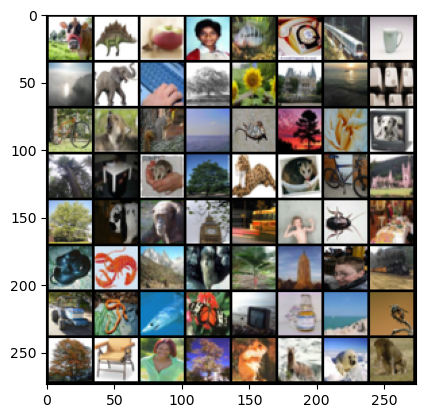

In [37]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x, t = next(train_iterator)

# Ensure the tensor is correctly moved to the GPU
x = x.to(device)
t = t.to(device)

# Plot the images
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0))
plt.show()

### Generator and Discriminator

In [38]:
# hyperparameters
batch_size = train_loader.batch_size
channels = 3
latent_dim = 100
image_size = 32
lr = 0.0002
num_classes = 100

check_interval = 5

num_of_epochs = 50000

Repo: https://github.com/atapour/dl-pytorch/blob/main/Conditional_GAN_Example/Conditional_GAN_Example.ipynb

In [39]:
# Self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial layer
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            SelfAttention(64),
            nn.ConvTranspose2d(64, channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 32x32 -> 16x16
            nn.Conv2d(channels, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4x4 -> 1x1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)
    
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

optimiser_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) # Adjusted from 0.002 and (0.5, 0.999)
optimiser_d = torch.optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999)) # Adjusted from 0.002 and (0.5, 0.999)

print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(generator.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(discriminator.parameters()))}')

criterion = nn.BCELoss()

> Number of generator parameters 3617553
> Number of discriminator parameters 2637312


### Main loop

[0/50000][0/781] Loss_D: 1.3896 Loss_G: 2.4659
[0/50000][100/781] Loss_D: 0.1664 Loss_G: 4.1256
[0/50000][200/781] Loss_D: 0.5804 Loss_G: 1.9274
[0/50000][300/781] Loss_D: 0.7367 Loss_G: 1.6701
[0/50000][400/781] Loss_D: 0.8630 Loss_G: 1.3058
[0/50000][500/781] Loss_D: 0.8256 Loss_G: 2.1863
[0/50000][600/781] Loss_D: 0.8253 Loss_G: 1.4595
[0/50000][700/781] Loss_D: 0.9090 Loss_G: 2.7757
[1/50000][0/781] Loss_D: 0.7056 Loss_G: 2.0290
[1/50000][100/781] Loss_D: 1.1004 Loss_G: 1.2891
[1/50000][200/781] Loss_D: 1.4042 Loss_G: 2.6313
[1/50000][300/781] Loss_D: 0.8139 Loss_G: 2.4574
[1/50000][400/781] Loss_D: 0.8917 Loss_G: 3.4535
[1/50000][500/781] Loss_D: 1.1018 Loss_G: 3.7212
[1/50000][600/781] Loss_D: 1.0563 Loss_G: 4.0679
[1/50000][700/781] Loss_D: 0.8443 Loss_G: 3.4747
[2/50000][0/781] Loss_D: 1.7431 Loss_G: 3.4010
[2/50000][100/781] Loss_D: 1.1875 Loss_G: 2.2053
[2/50000][200/781] Loss_D: 0.7336 Loss_G: 2.0911
[2/50000][300/781] Loss_D: 1.1230 Loss_G: 1.5206
[2/50000][400/781] Loss_D:

C:\Users\Billy\AppData\Local\Temp\ipykernel_29816\583789804.py:47: RuntimeWarning: Mean of empty slice.
  print(f'Epoch [{epoch+1}/{num_of_epochs}], Loss D: {dis_loss_arr.mean():.4f}, Loss G: {gen_loss_arr.mean():.4f}')


Epoch [5/50000], Loss D: nan, Loss G: nan


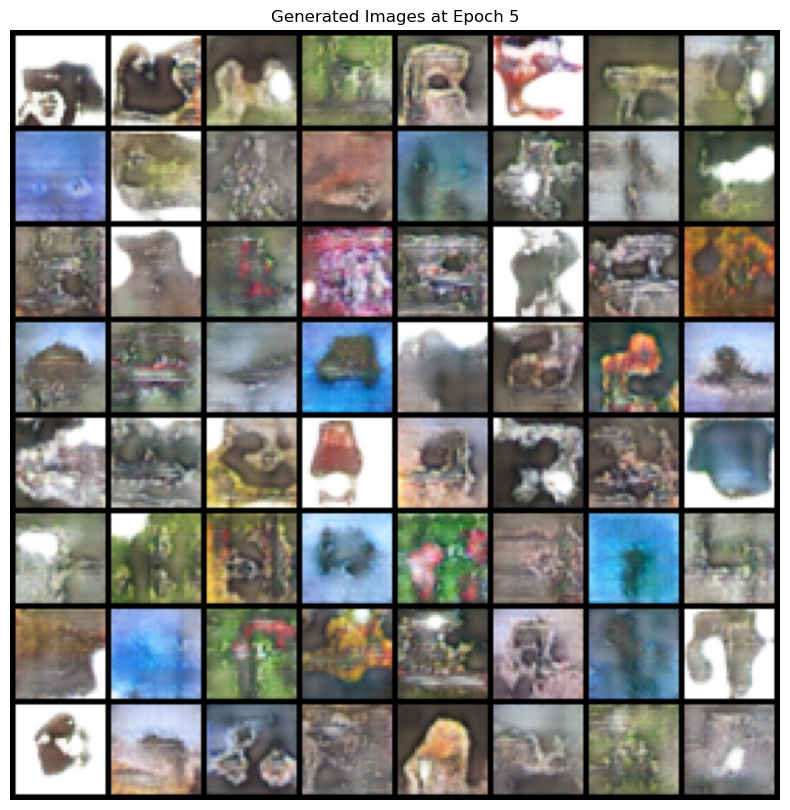

[5/50000][0/781] Loss_D: 0.8725 Loss_G: 1.5890
[5/50000][100/781] Loss_D: 0.8952 Loss_G: 1.8992
[5/50000][200/781] Loss_D: 1.4943 Loss_G: 1.0226
[5/50000][300/781] Loss_D: 1.0971 Loss_G: 1.4060
[5/50000][400/781] Loss_D: 0.9327 Loss_G: 1.4218
[5/50000][500/781] Loss_D: 1.4870 Loss_G: 2.7774
[5/50000][600/781] Loss_D: 0.9782 Loss_G: 2.2255
[5/50000][700/781] Loss_D: 1.1670 Loss_G: 2.3559
[6/50000][0/781] Loss_D: 1.3092 Loss_G: 0.9797
[6/50000][100/781] Loss_D: 1.0141 Loss_G: 2.4473
[6/50000][200/781] Loss_D: 1.5733 Loss_G: 2.4040
[6/50000][300/781] Loss_D: 1.0194 Loss_G: 1.8364
[6/50000][400/781] Loss_D: 1.0762 Loss_G: 1.0664
[6/50000][500/781] Loss_D: 1.1653 Loss_G: 0.9142
[6/50000][600/781] Loss_D: 0.9679 Loss_G: 2.6172


KeyboardInterrupt: 

In [40]:
real_label = 1
fake_label = 0

for epoch in range(num_of_epochs):
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    for i, (real_images, labels) in enumerate(train_loader):
        discriminator.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((batch_size,), real_label, device=device, dtype=torch.float)

        output = discriminator(real_images)
        d_loss_real = criterion(output, label)
        d_loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        label.fill_(fake_label).float()

        output = discriminator(fake_images.detach())
        d_loss_fake = criterion(output, label)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimiser_d.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_images)
        g_loss = criterion(output, label)
        g_loss.backward()
        optimiser_g.step()
        
        if i % 100 == 0:
                print(f'[{epoch}/{num_of_epochs}][{i}/{len(train_loader)}] '
                      f'Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f}')

    if (epoch + 1) % check_interval == 0:
        generator.eval()
        with torch.no_grad():
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            z = z.unsqueeze(2).unsqueeze(3)
            fake_images = generator(z)
            fake_images = (fake_images + 1) / 2
            print(f'Epoch [{epoch+1}/{num_of_epochs}], Loss D: {dis_loss_arr.mean():.4f}, Loss G: {gen_loss_arr.mean():.4f}')
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.title(f'Generated Images at Epoch {epoch+1}')
            plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images[:batch_size], padding=2, normalize=True).cpu(), (1, 2, 0)))
            plt.show()
        generator.train()

**Latent interpolations**

In [ ]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(batch_size))

z0 = z[0:col_size].repeat(col_size,1) # z for top row
z1 = z[batch_size-col_size:].repeat(col_size,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = generator.sample(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [7]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [9]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory} # remove any existing (old) data
    os.makedirs(directory)

# setup_directory(real_images_dir)
# setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(batch_size, latent_dim).to(device)
    samples_batch = N.sample(z).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [ ]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")